# 4TIN811U Machine Learning & Deep Learning
# TP 2 - Régression locale et régression logistique

## Commentaires généraux sur vos soumissions
- Merci de rendre uniquement le fichier `.ipynb`, sans le mettre dans une archive compressée.
- Si vous observez que vous obtenez des résultats incohérents mais que vous n'avez pas pu trouver l'erreur dans votre code, nous apprécions quand vous ajoutez un commentaire expliquant que vous savez que les résultats sont étranges, et que vous émettez une ou deux hypothèses sur ce qui pourrait être corrigé avec plus de temps. Par exemple, certains obtiennent une prédiction des prix qui croît en la distance au centre-ville ; essayez davantage d'interpréter et d'analyser vos résultats.
- Globalement, on préfère recevoir un TP incomplet mais qui fonctionne bien, plutôt que toutes les questions complétées mais sans que rien ne fonctionne. Par exemple, il n'est pas pertinent d'attaquer la régression locale à plusieurs dimensions si le cas à une dimension ne peut déjà pas s'exécuter sans erreur.

## Commentaires sur le TP2
- Pour la fonction de poids `weight`, notez qu'en général, la distance entre deux vecteurs est une norme et pas une valeur absolue. Pour beaucoup, cela limitait votre fonction `weight` à des points à une seule dimension.
- Pour ceux qui ont des lignes dans tous les sens sur les graphiques du poids, modifiez le paramètre "marker" de la fonction plot (ici, le paramètre "o" convenait bien).
- Une légère optimisation est possible pour certains qui avaient bien une fonction weight autorisant des vecteurs, au moment de calculer la norme au carré : pour plus d'efficacité et pour diminuer les erreurs numériques, ne pas faire `np.linalg.norm(x) ** 2` car cela passe par un calcul inutile (et plutôt coûteux) de racine carrée ; `np.inner(x, x)` donne le résultat voulu directement, sans calcul de racine carrée.
- Pour la multiplication matricielle, préférez `numpy.matmul()` à `np.dot()`. Le fonction `np.dot()` effectue également une multiplication matricielle quand on lui passe des matrices en entrée, mais a d'autres comportements quand on lui passe d'autres objets en entrée ; pour diminuer les risques d'erreurs, `numpy.matmul()` retourne une erreur quand les objets en entrée ne sont pas des matrices. 
- Pour la régression locale, évitez les calculs matriciels redondants ; ici, la multiplication "X.T @ W" était présente deux fois dans la formule, mais vous pouvez ne la calculer qu'une seule fois.
- Dans la méthode de Newton, évitez de calculer plusieurs fois f(x) inutilement (l'évaluation de certaines fonctions peut être coûteuse).
- Pour les deux racines de `f` : beaucoup ont trouvé "-1.000000000001768" et "-1" ; ces deux valeurs correspondent à la même racine (-1), la différence est juste due à l'erreur numérique et au epsilon choisi ! Le graphique suggère qu'il y a bien deux racines distinctes. Il fallait essayer ici quelques valeurs de départ différentes pour trouver les deux racines.
- Essayez de bien comprendre la différence entre les fonctions passées en paramètre de la méthode de Newton en fonction de si on cherche une racine ou un maximum/minimum.
- Pour la méthode de Newton multi-dimensionnelle : elle prend en entrée des fonctions qui ne dépendent que d'un paramètre (ici, theta) mais la fonction `gradient_l` (resp. `hessian_l`) prend trois (resp. deux) paramètres en entrée. Ici, X et Y étaient fixés ; une façon propre de contourner ce problème est de définir une fonction lambda avec un paramètre utilisant les valeurs fixées de X et Y. Par exemple pour le gradient : `gradient_l_theta = lambda theta: gradient_l(X, Y, theta)`.

In [27]:
# Cette option peut être décommentée pour améliorer la visualisation
# des figures, mais ne fonctionne pas sur tous les systèmes.
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# 1. Régression locale

Dans cette première partie, nous allons prédire [le prix des logements à Perth](https://www.kaggle.com/datasets/syuzai/perth-house-prices) en utilisant une régression locale à partir de deux informations : leur surface et leur distance au centre-ville.
Le dataset <code>dataset_tp2_houses.npy</code> est disponible dans le fichier <code>tp2.zip</code> sur Moodle et contient 1000 données d'entraînement.

In [28]:
house_prices = np.load("dataset_tp2_houses.npy") # 1000 données, trois colonnes : surface, distance du centre-ville, prix
print(np.shape(house_prices))
print(house_prices)

surfaces = house_prices[:,0]
distances = house_prices[:,1]
prices = house_prices[:,2]

(1000, 3)
[[    178   27400 1175000]
 [    227   38200  338000]
 [    137   18100  335000]
 ...
 [    236   29000  892500]
 [    114    2600 1030000]
 [     91   13400  316000]]


Affichez le graphique en 3D du prix des logements en fonction de leur surface et de leur distance au centre-ville.

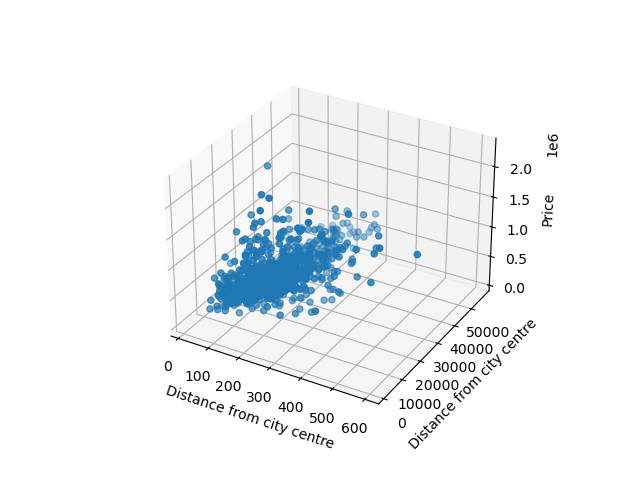

In [29]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(surfaces, distances, prices)
ax.set_xlabel("Distance from city centre")
ax.set_ylabel("Distance from city centre")
ax.set_zlabel("Price")
plt.show()

Implémentez la fonction de poids $w^{(i)}$ vue au cours, qui donne un poids à un élément $x^{(i)}$ des données d'entraînement en fonction d'un $x$ fixé et de l'hyperparamètre de bande passante $\tau$.

In [30]:
def weight(x, xi, tau):
    """Returns the weight to give xi from the training set
       with respect to a point x and with bandwidth tau."""
    diff = np.subtract(xi, x)
    return np.exp(- np.inner(diff, diff) / (2 * (tau ** 2)))

In [31]:
def weight_vector(x, X, tau):
    """Returns the vector of weights for each element of vector X
       with respect to a point x and with bandwidth tau."""
    return np.array([weight(x, xi, tau) for xi in X])

Pour un x fixé (par exemple, 20000), affichez dans un graphique les poids des différents éléments de la feature "distance au centre-ville". Essayez différentes valeurs de bande passante. Qu'observez-vous ? Qu'en est-il si vous passez à la feature "surface" ?

*Réponse :* Au plus $\tau$ est grand, au plus la courbe est "large", c'est-à-dire donne des poids non-négligeables à des points plus éloignés de $x$. Quand on passe à la feature "surface", on observe que les courbes sont beaucoup plus larges pour un même $\tau$. Cela est dû à la magnitude moins grande des données, qui ne varient qu'entre ~50 et ~600. Les différences sont donc beaucoup moins grandes en moyenne et, dans la formule, $\tau$ doit contrebalancer des numérateurs beaucoup moins grands. Un même $\tau$ n'est donc pas pertinent pour les deux features simultanément.

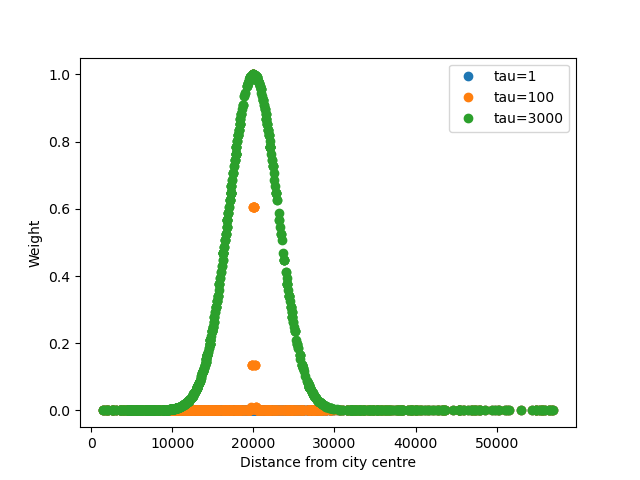

In [32]:
# Graphique pour la feature "distance au centre-ville"
plt.figure()
x = 20000
plt.plot(distances, weight_vector(x, distances, 1), "o", label="tau=1")
plt.plot(distances, weight_vector(x, distances, 100), "o", label="tau=100")
plt.plot(distances, weight_vector(x, distances, 3000), "o", label="tau=3000")
plt.legend()
plt.xlabel("Distance from city centre")
plt.ylabel("Weight")
plt.show()

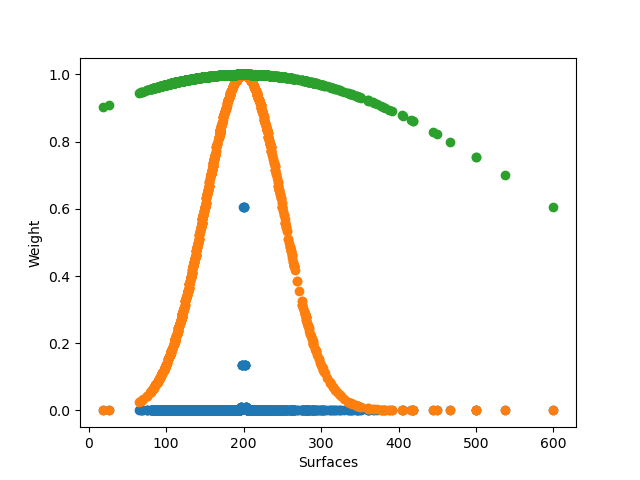

In [33]:
# Graphique pour la feature "surface"
plt.figure()
x = 200
plt.plot(surfaces, weight_vector(x, surfaces, 1), "o", label="tau=1")
plt.plot(surfaces, weight_vector(x, surfaces, 50), "o", label="tau=50")
plt.plot(surfaces, weight_vector(x, surfaces, 400), "o", label="tau=400")
plt.xlabel("Surfaces")
plt.ylabel("Weight")
plt.show()

### 1.1. Régression locale à une caractéristique

Dans cette première partie, on souhaite estimer le prix d'un logement à Perth en prenant *uniquement en compte la distance au centre-ville* (pour simplifier les calculs, on ignore pour le moment la surface). Effectuez un pré-traitement pour récupérer le $X$ et le $Y$ adaptés à partir de la variable <code>house_prices</code>. N'oubliez pas de prendre en compte le paramètre $\theta_0$ !

In [34]:
m, n = house_prices.shape
X = house_prices[:, 1:2]
X = np.concatenate((np.ones((m, 1)), X), axis=1)
Y = house_prices[:, n-1]

In [35]:
print(X.shape)
print(Y.shape)

(1000, 2)
(1000,)


Pour chaque $x$, calculez le vecteur $\theta$ minimisant la fonction d'erreur $J'_x(\theta)$ vue au cours pour la régression locale. Utilisez votre méthode favorite parmi celles vues au cours (ou utilisez les deux et comparez les résultats !).

In [38]:
# On utilise ici la méthode exacte.
def theta_minimizing_error(X, Y, x, tau, weight_function=weight_vector):
    m, _ = X.shape

    # Construction de la matrice W
    weights = weight_function(x, X, tau)
    W = np.zeros((m, m))
    for i in range(m):
        W[i][i] = .5 * weights[i]
    
    # Précalcul pour éviter une multiplication matricielle redondante
    XTW = X.T @ W

    # Formule exacte vue au cours
    return np.linalg.inv(XTW @ X) @ XTW @ Y

def prediction(X, Y, x, tau, weight_function=weight_vector):
    one_x = np.concatenate(([1], np.atleast_1d(x)))
    theta = theta_minimizing_error(X, Y, one_x, tau, weight_function=weight_function)
    return one_x.T @ theta

Affichez les prédictions données par votre fonction.

[928632.2392323791, 931594.206176209, 934026.5664703279, 935967.6503631414, 937454.70176594, 938523.5377616216, 939208.2229747629, 939540.7688718117, 939550.8674723034, 939265.667882066, 938709.6025540222, 937904.26832147, 936868.365140974, 935617.6932530382, 934165.2072538538, 932521.1235013246, 930693.0754700548, 928686.3102162735, 926503.9180783711, 924147.0871521841, 921615.3739405712, 918906.981853094, 916019.0398683805, 912947.874597792, 909689.2701227329, 906238.7112366756, 902591.6070268563, 898743.4930092457, 894690.2112240545, 890428.0687615031, 885953.9760848961, 881265.5672280614, 876361.3044546867, 871240.57027298, 865903.749801056, 860352.3063808972, 854588.8530482557, 848617.221991775, 842442.5334884756, 836071.265000433, 829511.320181013, 822772.0964986589, 815864.549083615, 808801.2472926817, 801596.4194375396, 794265.9802155346, 786827.5347098354, 779300.3524850704, 771705.3053871678, 764064.7632387519, 756402.4427530017, 748743.2066777629, 741112.8123850224, 733537.6

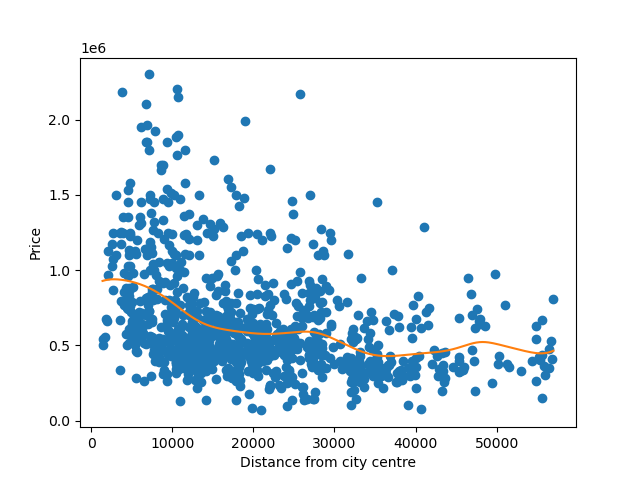

In [39]:
nb_points = 300
to_evaluate = np.linspace(np.min(X[:,1]), np.max(X[:,1]), nb_points)
plt.figure()
plt.plot(distances, Y, 'o')
plt.xlabel("Distance from city centre")
plt.ylabel("Price")

tau = 3000
predictions = [prediction(X, Y, x, tau) for x in to_evaluate]
print (predictions)
plt.plot(to_evaluate, predictions, '-')
plt.show()

### 1.2. Régression locale à plusieurs caractéristiques

En utilisant les mêmes fonctions, faites fonctionner votre méthode en prenant cette fois en compte les deux features "surface" et "distance du centre-ville". Affichez vos résultats sur un graphique en trois dimensions.

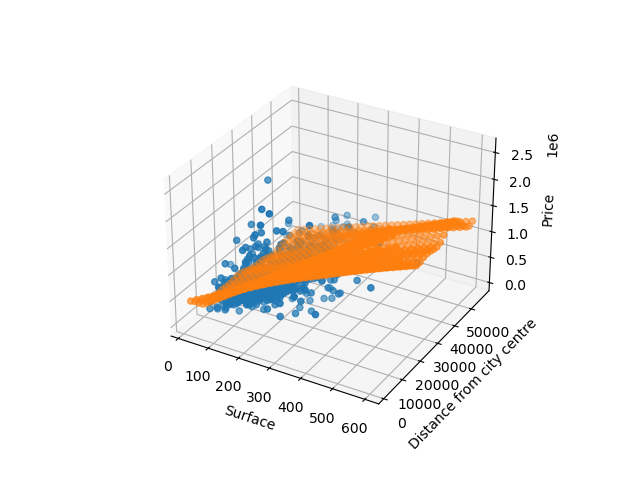

In [12]:
m, n = house_prices.shape
X = house_prices[:, 0:2]
X = np.concatenate((np.ones((m, 1)), X), axis=1)
Y = house_prices[:, n-1]

ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(X[:,1], X[:,2], Y)
ax.set_xlabel("Surface")
ax.set_ylabel("Distance from city centre")
ax.set_zlabel("Price")

t0 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
t1 = np.linspace(np.min(X[:,2]), np.max(X[:,2]), 30)
to_evaluate = np.array([[x0, x1] for x0 in t0 for x1 in t1])
tau = 3000
predictions = [prediction(X, Y, x, tau) for x in to_evaluate]
ax.scatter3D(to_evaluate[:,0], to_evaluate[:,1], predictions)
plt.show()

En fonction de votre choix de bande passante $\tau$, il est probable que selon une des deux dimensions, les prédictions soient linéaires. À quoi cela peut-il être dû ?

*Réponse :* Cela est dû au fait que, comme discuté plus haut, un même $\tau$ n'est pas pertinent pour les deux dimensions à la fois. Ici, le $\tau$ choisi (3000) donne une bonne fonction de poids pour la feature "Distance from city center", mais les variations de surface n'ont presque aucun impact sur le poids. Cela implique que selon la dimension "surface", les prédictions sont linéaires car quand les poids sont proches de $1$, la régression locale ressemble à une régression linéaire.

Pour remédier à cela, il peut être utile de *normaliser* les données.
Ré-appliquez vos fonctions en vous assurant que les éléments de $X$ ont la même magnitude selon chaque dimension.

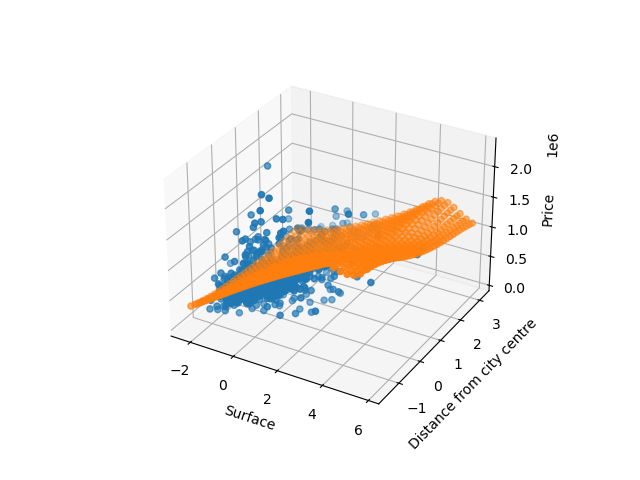

In [13]:
from sklearn.preprocessing import StandardScaler

m, n = house_prices.shape
X = np.concatenate((house_prices[:, 0:1], house_prices[:, 1:2]), axis=1)
Y = house_prices[:, n-1]

# Normalisation utilisant StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = np.concatenate((np.ones((m, 1)), X), axis=1)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(X[:,1], X[:,2], Y)
ax.set_xlabel("Surface")
ax.set_ylabel("Distance from city centre")
ax.set_zlabel("Price")

t0 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
t1 = np.linspace(np.min(X[:,2]), np.max(X[:,2]), 30)
to_evaluate = np.array([[x0, x1] for x0 in t0 for x1 in t1])
tau = 1
predictions = [prediction(X, Y, x, tau) for x in to_evaluate]
ax.scatter3D(to_evaluate[:,0], to_evaluate[:,1], predictions)
plt.show()

Généralisez vos fonctions afin de pouvoir facilement changer la fonction de poids utilisée.
Utilisez la fonction de poids $w^{(i)} = 1$ et commentez le résultat.

*Réponse :* En appliquant une fonction de poids constante, tous les données ont le même poids, indépendamment de la distance au point évalué. On retombe en fait exactement sur la régression linéaire classique (comme au TP1), qui est généralisée par la régression locale quand les poids ne sont pas constants. Les prédictions sont donc linéaires et forment un plan de l'espace.

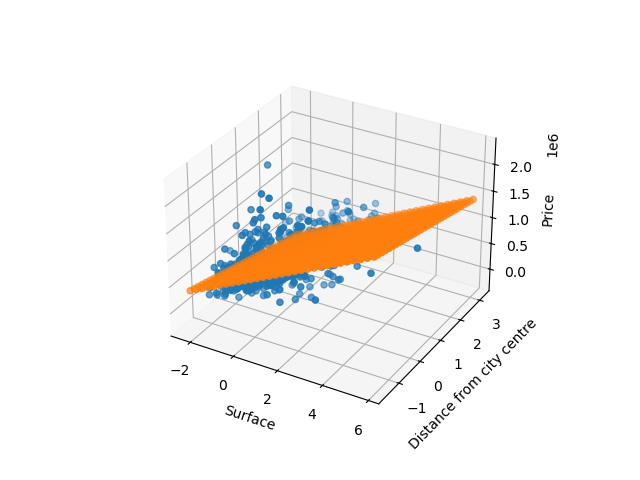

In [14]:
from sklearn.preprocessing import StandardScaler

def identity_weight(x, X, tau):
    return [1 for _ in X]

m, n = house_prices.shape
X = np.concatenate((house_prices[:, 0:1], house_prices[:, 1:2]), axis=1)
Y = house_prices[:, n-1]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.concatenate((np.ones((m, 1)), X), axis=1)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(X[:,1], X[:,2], Y)
ax.set_xlabel("Surface")
ax.set_ylabel("Distance from city centre")
ax.set_zlabel("Price")

t0 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
t1 = np.linspace(np.min(X[:,2]), np.max(X[:,2]), 30)
to_evaluate = np.array([[x0, x1] for x0 in t0 for x1 in t1])
tau = 1
predictions = [prediction(X, Y, x, tau, weight_function=identity_weight) for x in to_evaluate]
ax.scatter3D(to_evaluate[:,0], to_evaluate[:,1], predictions)
plt.show()

## 2. Méthode de Newton

On considère la fonction $$f(x) = x^4 + 3x^3 - 6x^2 + 4x + 12.$$

En utilisant la méthode de Newton (à une dimension), calculez
* ses racines,
* son minimum global.

Utilisez la même fonction <code>newton_1d</code> (avec des arguments différents) pour les deux tâches données.
Aidez-vous du graphe de $f$.

In [15]:
def f(x):
    return x**4 + 3 * x**3 - 6 * x**2 + 4 * x + 12

def df(x):
    """Computes the derivative of f at point x."""
    return 4 * x**3 + 9 * x**2 - 12 * x + 4

def ddf(x):
    """Computes the second derivative of f at point x."""
    return 12 * x**2 + 18 * x - 12

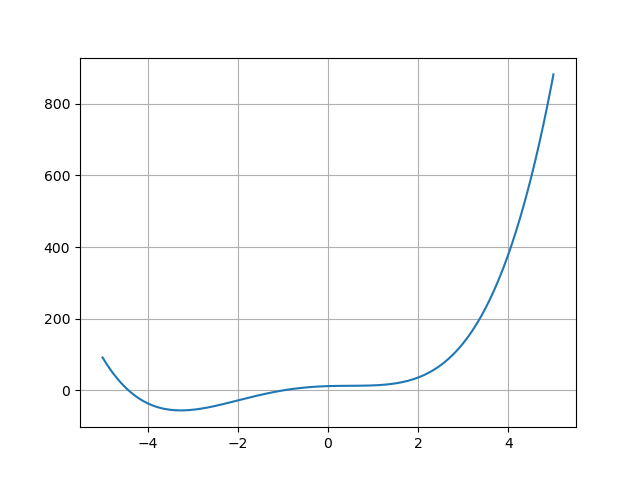

In [16]:
# Graphe de f entre -5 et 5
plt.figure()
values = np.linspace(-5, 5, 10000)
plt.plot(values, [f(x) for x in values], "-")
plt.grid()
plt.show()

In [17]:
def newton_1d(f, df, x0, max_iter=1000, epsilon=1e-10):
    """Finds a root of f given its derivative df and an initial guess x0.
       Assumes that a value x is a root if abs(f(x)) < epsilon.
       Raises an exception if no such value is found within max_iter iterations."""
    fx0 = f(x0)
    i = 0
    while abs(fx0) > epsilon and i < max_iter:
        x0 = x0 - fx0 / df(x0)
        fx0 = f(x0)
        i += 1
    if abs(fx0) > epsilon and i >= max_iter:
        raise Exception("No root of f found in newton_1d within the given number of iterations.")
    return x0

Racines :  -4.422485405929016 -1.000000000001768
Minimum :  -3.263239680755825


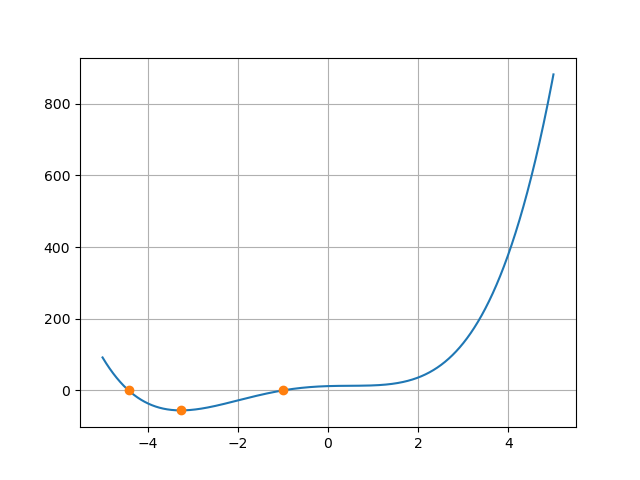

In [18]:
# Find the two roots and the global minimum using newton_1d
# Les valeurs de départ donnant les deux racines ont été obtenues après quelques tests de valeurs initiales différentes
r1 = newton_1d(f, df, 3)
r2 = newton_1d(f, df, 0)
print("Racines : ", r1, r2)

minimum = newton_1d(df, ddf, 3)
print("Minimum : ", minimum)

plt.figure()
values = np.linspace(-5, 5, 10000)
plt.plot(values, [f(x) for x in values], "-")
plt.plot([r1, r2, minimum], [f(r1), f(r2), f(minimum)], "o")
plt.grid()
plt.show()

## 3. Régression logistique
Dans cette partie, on souhaite prédire [la qualité de pommes](https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality/data) en utilisant une régression logistique à partir de deux informations : leur taille et leur *sweetness*. Le deux features sont des réels (déjà normalisés) et la qualité est un entier dans $\{0, 1\}$ : $1$ pour les bonnes pommes et $0$ pour les mauvaises pommes.
Le dataset <code>dataset_tp2_apples.npy</code> est disponible dans le fichier <code>tp2.zip</code> sur Moodle et contient 1000 données d'entraînement.

In [19]:
# 1000 données, trois colonnes : taille, sweetness et qualité
apple_quality = np.load("dataset_tp2_apples.npy", allow_pickle=True)
print(np.shape(apple_quality))
print(apple_quality)

size = apple_quality[:,0]
sweetness = apple_quality[:,1]
quality = apple_quality[:,2]

(1000, 3)
[[-2.79942712 1.645971316 0]
 [-3.005490261 2.24018426 0]
 [-1.111047637 -1.147093478 0]
 ...
 [0.46606931 1.024727597 1]
 [-3.324922798 0.784172063 0]
 [5.189624452 0.674040928 1]]


Affichez un graphique en 2D (une dimension par feature) reprenant les différentes données, en utilisant des symboles différents pour les bonnes et les mauvaises pommes.

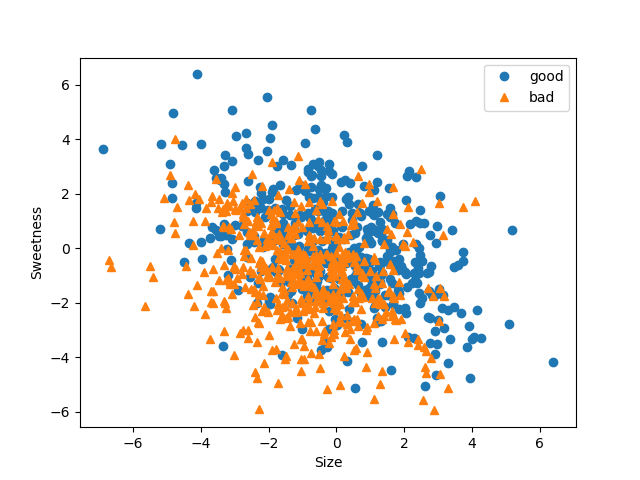

In [20]:
plt.figure()
good_idx = np.where(quality == 1)
bad_idx = np.where(quality == 0)
plt.plot(size[good_idx], sweetness[good_idx], "o", label="good")
plt.plot(size[bad_idx], sweetness[bad_idx], "^", label="bad")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Sweetness")
plt.show()

Nous avons vu au cours que la fonction de log-vraisemblance pour la régression logistique est la suivante:
$$\ell(\theta) = \sum_{i = 1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log(1 - h_\theta(x^{(i)})),$$
où $h_\theta(x^{(i)}) = \frac{1}{1 + e^{-\theta^{T}x^{(i)}}}$.

Nous avons aussi vu que les dérivées partielles de $\ell$ sont
$$\frac{\partial}{\partial\theta_j}\ell(\theta) = \sum_{i=1}^m (y^{(i)} - h_\theta(x^{(i)}))x_j^{(i)}.$$

On peut donc calculer les entrées de la matrice hessienne: pour $0 \le j, k \le n$, l'élément en position $(j, k)$ est donné par
$$
\begin{align}
H_{jk}(\theta) &= \frac{\partial^2}{\partial\theta_j\partial\theta_k} \ell(\theta) \\
       &= \sum_{i = 1}^m -\frac{\partial}{\partial\theta_j}h_\theta(x^{(i)})x^{(i)}_k \\
       &= -\sum_{i = 1}^m h_\theta(x^{(i)})(1 - h_\theta(x^{(i)}))x^{(i)}_j x^{(i)}_k.
\end{align}
$$
(Assurez-vous de pouvoir suivre les calculs !)

*Remarque* : Nous avons déclaré au cours (sans preuve) que $\ell$ est concave, et a donc un seul maximum local, qui est de plus global. Cela peut en fait se prouver en analysant les propriétés de la matrice hessienne: celle-ci est *semi-définie négative* pour tout $\theta$, c'est-à-dire, pour tout $z\in\mathbb{R}^{n+1}$, $z^TH(\theta)z \le 0$. Cela peut se vérifier (exercice !) avec la définition ci-dessus.
Cette propriété est la généralisation multi-dimensionnelle de la propriété "pour $f\colon \mathbb{R} \to \mathbb{R}$, $f$ est concave si $f'' < 0$".

Implémentez des fonctions qui calculent $h_\theta$, le gradient de $\ell$ et la matrice hessienne de $\ell$. Notez que la matrice hessienne ne dépend plus de $Y$ !

In [21]:
def h(xi, theta):
    return 1 / (1 + np.exp(-theta.T @ xi))

def gradient_l(X, Y, theta):
    m, n = X.shape
    commonFactor = np.zeros((m))
    for i in range(0, m):
        commonFactor[i] = Y[i] - h(X[i], theta)
    gradient = np.zeros((n))
    for j in range(0, n):
        for i in range(0, m):
            gradient[j] += commonFactor[i] * X[i][j]
    return gradient

def hessian_l(X, theta):
    m, n = X.shape
    commonFactor = np.zeros((m))
    for i in range(0, m):
        hxi = h(X[i], theta)
        commonFactor[i] = hxi * (1 - hxi)
    H = np.zeros((n, n))
    for j in range(0, n):
        for k in range(0, n):
            for i in range(0, m):
                H[j][k] -= commonFactor[i] * X[i][j] * X[i][k]
    return H

Utilisez la matrice hessienne et la méthode de Newton (multi-dimensionnelle cette fois) pour trouver les valeurs $\theta = (\theta_0, \theta_1, \theta_2)$ maximisant la vraisemblance.

In [22]:
def newton_multidim(f, df, theta_0, max_iter=1000, epsilon=1e-6):
    """Finds a root of multivariate function f given its gradient df and an initial guess theta_0.
       Assumes that a value theta is a root if np.linalg.norm(f(theta)) < epsilon.
       Raises an exception if no such value is found within max_iter iterations."""
    f_theta_0 = f(theta_0)
    i = 0
    while np.linalg.norm(f_theta_0) > epsilon and i < max_iter:
        theta_0 = theta_0 - np.linalg.inv(df(theta_0)) @ f_theta_0
        f_theta_0 = f(theta_0)
        i += 1
    if np.linalg.norm(f_theta_0) > epsilon and i >= max_iter:
        raise Exception("No root of f found in newton_multidim within the given number of iterations.")
    return theta_0

Ajoutez à votre graphique précédent la frontière de décision (qui est la droite telle que $\theta^Tx = 0$ pour le vecteur $\theta$ à trouver, qui correspond à la droite des points $x$ donnant la valeur $\frac{1}{2}$ à la fonction sigmoïde) donnée par la régression logistique.

[0.32023442 0.42093101 0.45556095]


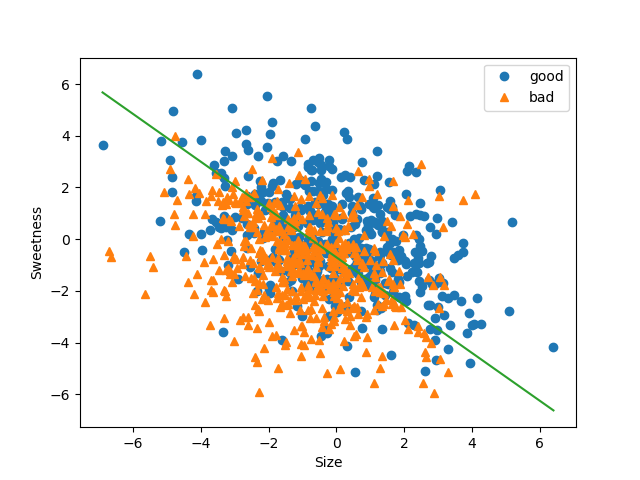

In [23]:
X = apple_quality[:, 0:2]
m, n = X.shape
X = np.concatenate((np.ones((m, 1)), X), axis=1)
Y = apple_quality[:, 2]

gradient_l_theta = lambda theta: gradient_l(X, Y, theta)
H_theta = lambda theta: hessian_l(X, theta)
theta_max = newton_multidim(gradient_l_theta, H_theta, np.zeros((n+1)))
print(theta_max)

plt.figure()
good_idx = np.where(quality == 1)
bad_idx = np.where(quality == 0)
plt.plot(size[good_idx], sweetness[good_idx], "o", label="good")
plt.plot(size[bad_idx], sweetness[bad_idx], "^", label="bad")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Sweetness")

to_evaluate = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 100)
plt.plot(to_evaluate, [(-theta_max[0] - theta_max[1] * x) / theta_max[2] for x in to_evaluate], "-")
plt.show()